In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import random
import numpy as np

In [19]:
df = pd.read_csv("data/dataset1.txt")

display(df.head())
print(df.shape)

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


(10000, 3)


In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None


In [21]:
print(df.isnull().sum())
df.duplicated().sum()

x        0
y        0
class    0
dtype: int64


0

In [22]:
df.describe()

,x,y,class
count,10000.000000,10000.000000,10000.000000
mean,89.981670,90.003827,49.500000
std,57.457467,57.559719,28.867513
min,-5.000000,-4.999860,0.000000
25%,40.237885,40.133840,24.750000
50%,89.999995,90.000080,49.500000
75%,139.898800,139.977695,74.250000
max,184.999920,185.000000,99.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


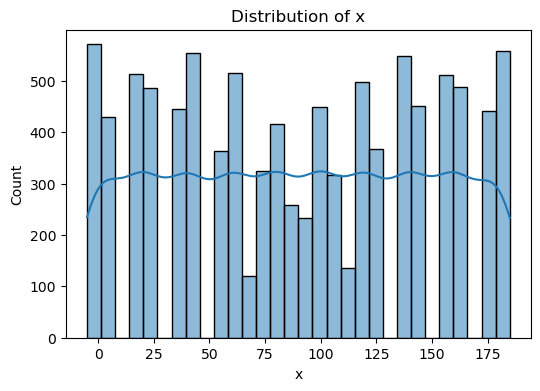

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


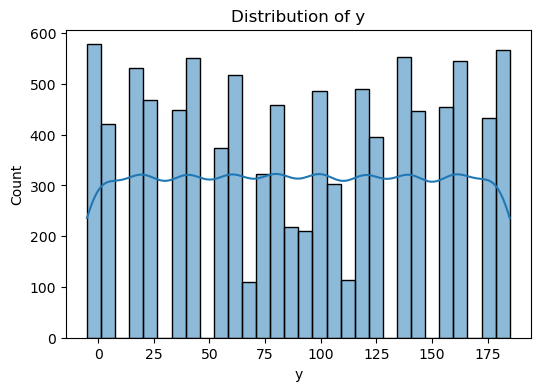

In [23]:
for col in df.columns:
    if col == "class":
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

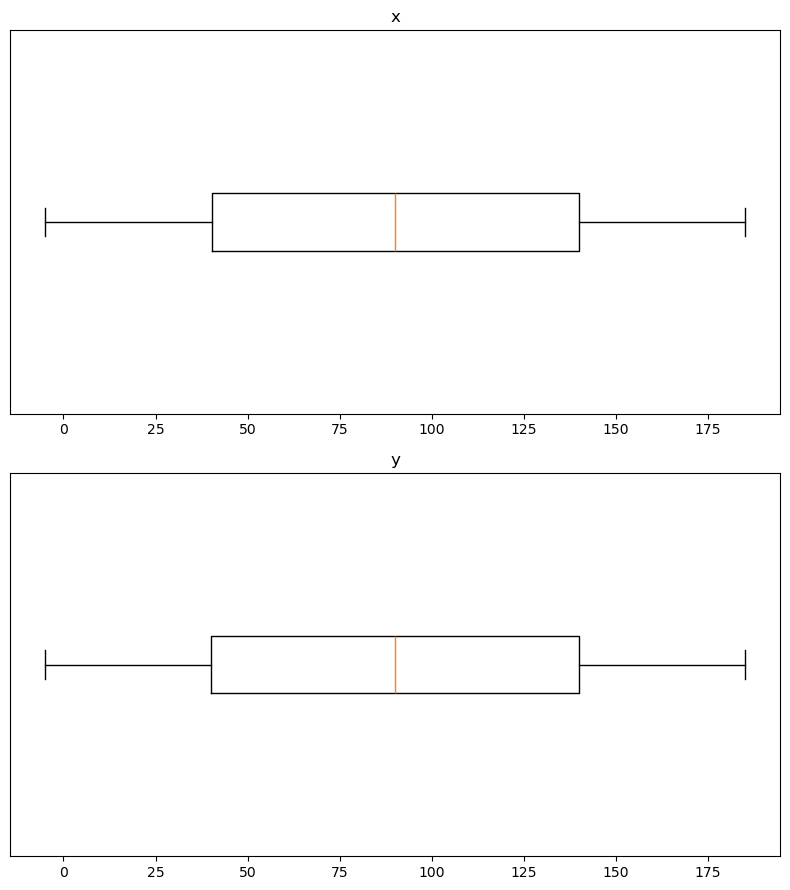

In [26]:
fig, axs = plt.subplots(len(df.columns)-1, 1, figsize=(8, 3*len(df.columns)), dpi=100)

if len(df.columns) == 1:
    axs = [axs]

for i, col in enumerate(df.columns):
    if col=="class":
        continue
    axs[i].boxplot(df[col].dropna(), vert=False)
    axs[i].set_title(col)   
    axs[i].set_yticks([]) 

plt.tight_layout()
plt.show()

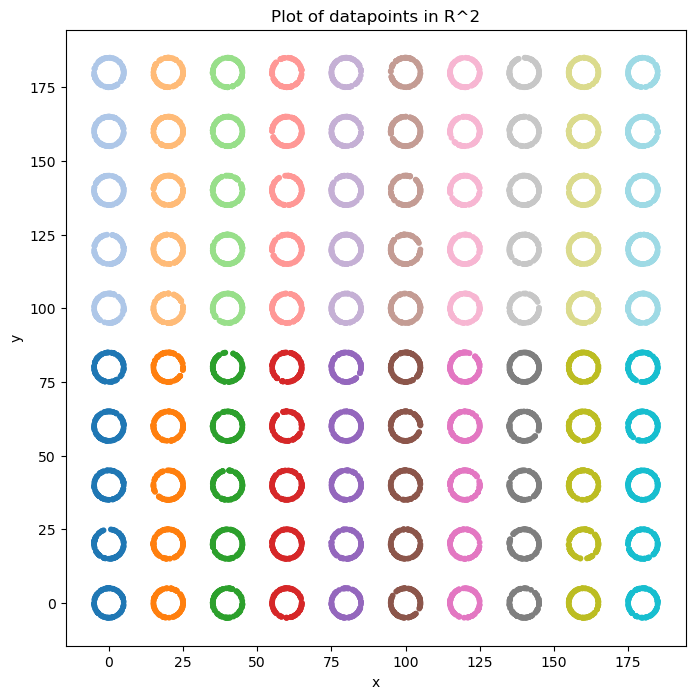

In [32]:
plt.figure(figsize = (8,8))
plt.scatter(df["x"], df["y"],c=df['class'], cmap="tab20", s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of datapoints in R^2")
plt.show()

In [36]:
X = df[["x", "y"]].copy()
y = df['class'].copy()

In [40]:
def standardize(col):
    mu = X[col].mean()
    sigma = X[col].std()
    X.loc[:, col] = (X[col] - mu)/sigma

for col in X.columns:
    standardize(col)

display(X.head())

,x,y
0,-1.511116,0.453767
1,-1.285078,-1.271501
2,0.179793,-0.434567
3,-1.589339,-0.090100
4,0.250474,-0.479156


In [42]:
def norm(p1, p2):
    return sqrt((p2['x']-p1['x'])^2 + (p2['y']-p1['y'])^2)

In [58]:
def k_means(df, k):
    centers = []
    clusters = []
    for i in range (1, k+1):
        rand_row = random.randint(0, df.shape[1])
        centers.append(df.iloc[rand_row])
        clusters.append([df.iloc[rand_row]])
    
    for j in range(df.shape[1]):
        p_j = df.iloc[j]
        min = (float('inf'), 0)
        for i in range(centers):
            dist = norm(p_j, c[i])
            if dist<min[0]:
                min = (dist, i)
        clusters[min[1]].append(p_j)
        
    for i in range(centers):
        new_mu = {}
        new_mu["x"] = 



In [59]:
k_means(X, 5)

-1.271500769291238
